In [53]:
import numpy as np
import hypertools as hyp
import matplotlib.pyplot as plt
import cortex
import tables
from scipy.spatial.distance import cdist

from stimulus_utils import load_grids_for_stories, load_generic_trfiles
from dsutils import make_word_ds, make_semantic_model
from npp import zscore
from util import make_delayed
from ridge import bootstrap_ridge


from nltk.corpus import stopwords

import logging
logging.basicConfig(level=logging.DEBUG)

% matplotlib inline

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


### load two semantic models for comparison

In [2]:
# import Huth et al. (2016)'s semantic model
from SemanticModel import SemanticModel

In [3]:
# Huth's semantic model
eng1000 = SemanticModel.load("../data/english1000sm.hf5")

DEBUG:SemanticModel:Loading file: data/english1000sm.hf5
DEBUG:SemanticModel:Done loading file..


In [4]:
# Latent Dirichlet Allocation model pre-trained on 1,000,000 wikipedia pages
LDA_wiki = hyp.load('wiki_model')
wiki_params = LDA_wiki.get_params()

In [6]:
# stories for fitting regression mdoels
Rstories = ['alternateithicatom', 'avatar', 'howtodraw', 'legacy', 'life', 'myfirstdaywiththeyankees', 
                    'naked', 'odetostepfather', 'souls', 'undertheinfluence']

# story for testing regression models/predicting activity
Pstories = ['wheretheressmoke']

allstories = Rstories + Pstories

### load TR-aligned story data

In [7]:
# Load TextGrids
grids = load_grids_for_stories(allstories)

# Load TRfiles
trfiles = load_generic_trfiles(allstories)

# Make word datasequences
wordseqs = make_word_ds(grids, trfiles) # dictionary of {storyname : word DataSequence}

In [8]:
# example:
# story text:
print(' '.join(wordseqs['life'].data[:100]))

# Words during 10 TRs:
wordseqs['life'].chunks()[:10]

so i get a phone call from my mom and she tells me that my father is about to get on an emergency life flight from our home in montana to go to denver to get an emergency liver transplant my mom is kinda perennially optimistic and she's telling me don't worry it's gonna be ok we're gonna pull through this it's gonna be alright but i know something is is really wrong so i get the next flight i can to go from where i'm living here in new york hoping that i get there before my father dies


[array([], dtype='<U13'),
 array([], dtype='<U13'),
 array([], dtype='<U13'),
 array([], dtype='<U13'),
 array([], dtype='<U13'),
 array(['so', 'i', 'get', 'a', 'phone', 'call'], dtype='<U13'),
 array(['from', 'my', 'mom'], dtype='<U13'),
 array(['and', 'she', 'tells', 'me'], dtype='<U13'),
 array(['that', 'my', 'father', 'is'], dtype='<U13'),
 array(['about', 'to', 'get', 'on', 'an', 'emergency', 'life'],
       dtype='<U13')]

# project stimuli into each semantic space

### Huth semantic space first:

In [9]:
huthseqs = dict()
for story in allstories:
    huthseqs[story] = make_semantic_model(wordseqs[story], eng1000)

### LDA topic space next:

In [10]:
ldaseqs = dict()
for story in allstories:
    vecs = np.empty((len(wordseqs[story].data), 100))
    for ix, word in enumerate(wordseqs[story].data):
        vecs[ix] = LDA_wiki.transform([word])
    ldaseqs[story] = vecs

# downsample stimuli to TR time scale

### Huth semantic vectors first:

In [11]:
interptype = "lanczos" # filter type
window = 3 # number of lobes in Lanczos filter

downsampled_huthseqs = dict() # dictionary to hold downsampled stimuli
for story in allstories:
    downsampled_huthseqs[story] = huthseqs[story].chunksums(interptype, window=window)

Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


### LDA topic vectors next:

In [12]:
# adapted from https://github.com/HuthLab/speechmodeltutorial/blob/master/interpdata.py

def lanczosinterp2D(data, oldtime, newtime, window=3, cutoff_mult=1.0):
    
    """Interpolates the columns of [data], assuming that the i'th row of data corresponds to
    oldtime(i). A new matrix with the same number of columns and a number of rows given
    by the length of [newtime] is returned.
    
    The time points in [newtime] are assumed to be evenly spaced, and their frequency will
    be used to calculate the low-pass cutoff of the interpolation filter.
    
    [window] lobes of the sinc function will be used. [window] should be an integer.
    """
    
    # Find the cutoff frequency
    cutoff = 1/np.mean(np.diff(newtime)) * cutoff_mult
    print ("Doing lanczos interpolation with cutoff=%0.3f and %d lobes." % (cutoff, window))
    
    # Build up sinc matrix
    lancmat = np.zeros((len(newtime), len(oldtime)))
    for ndi in range(len(newtime)):
        lancmat[ndi,:] = lanczosfun(cutoff, newtime[ndi]-oldtime, window)
    
    # Construct new signal by multiplying the sinc matrix by the data
    newdata = np.dot(lancmat, data)

    return newdata

def lanczosfun(cutoff, t, window=3):
    
    """Compute the lanczos function with some cutoff frequency [B] at some time [t].
    If given a [window], only the lowest-order [window] lobes of the sinc function
    will be non-zero.
    """
    
    t = t * cutoff
    val = window * np.sin(np.pi*t) * np.sin(np.pi*t/window) / (np.pi**2 * t**2)
    val[t==0] = 1.0
    val[np.abs(t)>window] = 0.0
    return val

In [13]:
downsampled_ldaseqs = dict() # dictionary to hold downsampled stimuli
for story in allstories:
    downsampled_ldaseqs[story] = lanczosinterp2D(ldaseqs[story], huthseqs[story].data_times, 
                                                 huthseqs[story].tr_times, window=window)

Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


# concatenate vectors across stories

### Huth first:

In [14]:
trim = 5
HuthRstim = np.vstack([zscore(downsampled_huthseqs[story][5+trim:-trim]) for story in Rstories])
HuthPstim = np.vstack([zscore(downsampled_huthseqs[story][5+trim:-trim]) for story in Pstories])

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


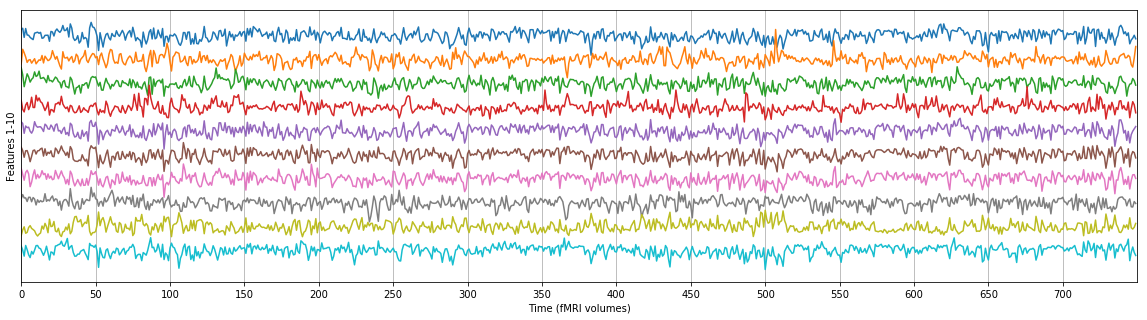

In [15]:
# Plot some of the combined stimuli
f = plt.figure(figsize=(20, 5))
ax = f.add_subplot(1,1,1)

for ii in range(10):
    # Plot each feature, offset by 5 vertically so they are easier to see
    ax.plot(HuthRstim[:750,ii] - 5 * ii)

ax.set_xlim(0, 750)
ax.set_yticks([])
ax.set_xticks(range(0, 750, 50))
ax.set_xlabel("Time (fMRI volumes)")
ax.set_ylabel("Features 1-10")
ax.grid()

### LDA next:

In [16]:
LDARstim = np.vstack([zscore(downsampled_ldaseqs[story][5+trim:-trim]) for story in Rstories])
LDAPstim = np.vstack([zscore(downsampled_ldaseqs[story][5+trim:-trim]) for story in Pstories])

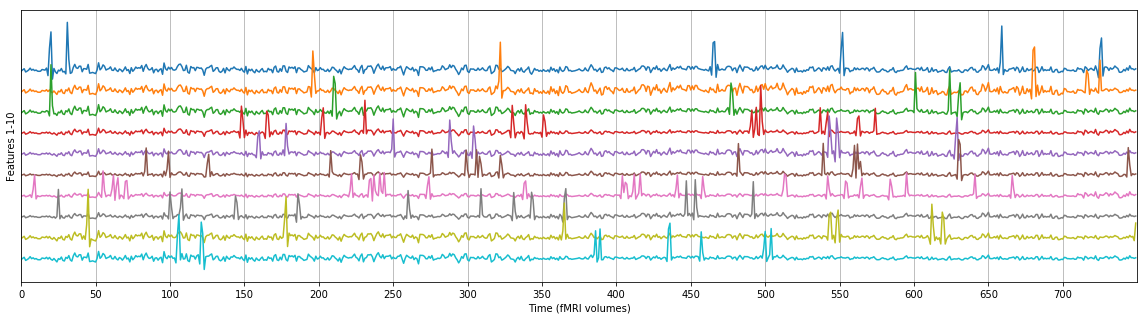

In [131]:
# Plot some of the combined stimuli
f = plt.figure(figsize=(20, 5))
ax = f.add_subplot(1,1,1)

for ii in range(10):
    # Plot each feature, offset by 5 vertically so they are easier to see
    ax.plot(LDARstim[:750,ii] - 5 * ii)

ax.set_xlim(0, 750)
ax.set_yticks([])
ax.set_xticks(range(0, 750, 50))
ax.set_xlabel("Time (fMRI volumes)")
ax.set_ylabel("Features 1-10")
ax.grid()

# concatenate delays for FIR model

### Huth:

In [18]:
# using 4 delays
delays = range(1, 5)

delHuthRstim = make_delayed(HuthRstim, delays)
delHuthPstim = make_delayed(HuthPstim, delays)

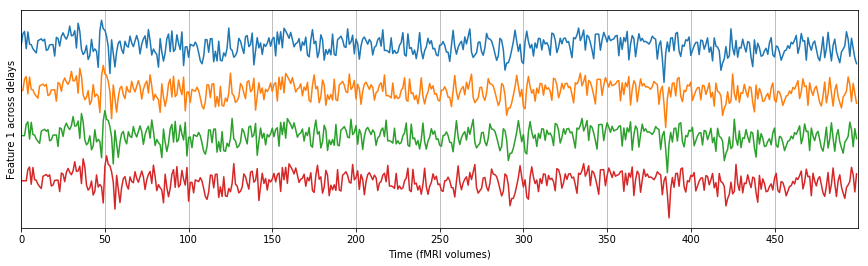

In [19]:
# Plot the same feature at different delays
f = plt.figure(figsize=(15, 4))
ax = f.add_subplot(1,1,1)
for ii in range(4):
    ax.plot(delHuthRstim[:500, ii * HuthRstim.shape[1]] - 5 * ii)
ax.set_xlim(0, 500)
ax.set_yticks([])
ax.set_xticks(range(0, 500, 50))
ax.set_xlabel("Time (fMRI volumes)")
ax.set_ylabel("Feature 1 across delays")
ax.grid()

### LDA:

In [20]:
delLDARstim = make_delayed(LDARstim, delays)
delLDAPstim = make_delayed(LDAPstim, delays)

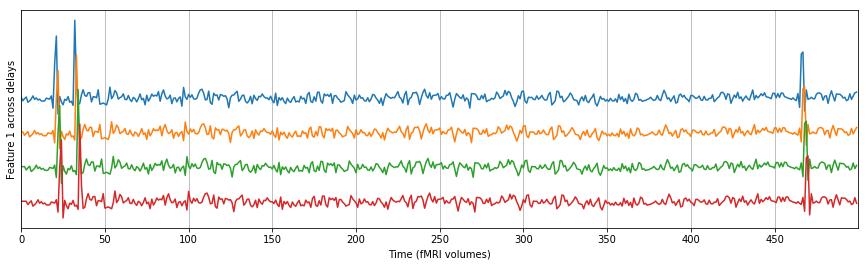

In [21]:
# Plot the same feature at different delays
f = plt.figure(figsize=(15, 4))
ax = f.add_subplot(1,1,1)
for ii in range(4):
    ax.plot(delLDARstim[:500, ii * LDARstim.shape[1]] - 5 * ii)
ax.set_xlim(0, 500)
ax.set_yticks([])
ax.set_xticks(range(0, 500, 50))
ax.set_xlabel("Time (fMRI volumes)")
ax.set_ylabel("Feature 1 across delays")
ax.grid()


# load fMRI data

In [22]:
resptf = tables.open_file("../data/fmri-responses.hf5")
zRresp = resptf.root.zRresp.read()
zPresp = resptf.root.zPresp.read()
mask = resptf.root.mask.read()

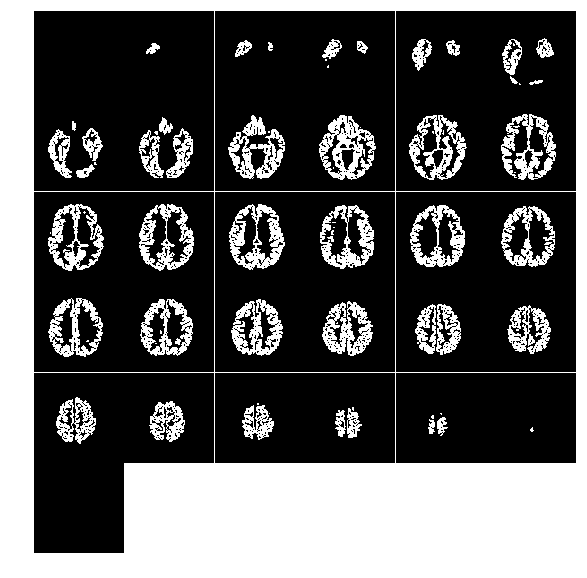

In [23]:
f = plt.figure(figsize=(10,10))
cortex.mosaic(mask, cmap=plt.cm.gray, interpolation="nearest")
plt.show()

# Fit regression model to predict voxel responses

In [24]:
alphas = np.logspace(1, 3, 10)
nboots = 1
chunklen = 40
nchunks = 20

### Huth model:

In [25]:
Hwt, Hcorr, Halphas, Hbscorrs, Hvalinds = bootstrap_ridge(delHuthRstim, zRresp, delHuthPstim, zPresp, alphas, 
                                                          nboots, chunklen, nchunks, singcutoff=1e-10, 
                                                          single_alpha=True)

INFO:ridge_corr:Selecting held-out test set..
INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 1 tiny singular values.. (U is now (2937, 2936))
INFO:ridge_corr:Training stimulus has Frobenius norm: 1296.489
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.02608, max corr=0.24132, over-under(0.20)=26
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.03047, max corr=0.25698, over-under(0.20)=107
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.03534, max corr=0.29011, over-under(0.20)=292
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.04056, max corr=0.33040, over-under(0.20)=626
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.04531, max corr=0.35376, over-under(0.20)=1003
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.04833, max corr=0.37267, over-under(0.20)=1280
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.04909, max corr=0.38721, over-under(0.20)=1365
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.04749, max corr=0.38134, over-under(0.20)=1268

DEBUG:matplotlib.font_manager:findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXGeneral ('/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=STIXGeneral:style=italic:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXGeneral ('/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=bold:stretch=normal:size=10.0 to STIXGeneral ('/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf') with score of 0.000000
DEBUG:matplotlib.font_manager:findfont: Matching :family=STIXNonUnicode:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXNonUnicode ('/usr/local/lib/python3.6/site-packages/matplo

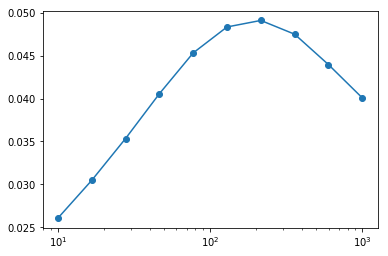

In [27]:
f = plt.figure()
ax = f.add_subplot(1,1,1)
ax.semilogx(np.logspace(1, 3, 10), Hbscorrs.mean(2).mean(1), 'o-')

### LDA model

In [28]:
Lwt, Lcorr, Lalphas, Lbscorrs, Lvalinds = bootstrap_ridge(delLDARstim, zRresp, delLDAPstim, zPresp, alphas, 
                                                          nboots, chunklen, nchunks, singcutoff=1e-10, 
                                                          single_alpha=True)

INFO:ridge_corr:Selecting held-out test set..
INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 400))
INFO:ridge_corr:Training stimulus has Frobenius norm: 283.423
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01756, max corr=0.27327, over-under(0.20)=10
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.01816, max corr=0.28238, over-under(0.20)=12
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.01952, max corr=0.30127, over-under(0.20)=20
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.02203, max corr=0.32921, over-under(0.20)=38
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.02562, max corr=0.35162, over-under(0.20)=76
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.02883, max corr=0.35911, over-under(0.20)=99
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02966, max corr=0.36050, over-under(0.20)=105
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.02908, max corr=0.36141, over-under(0.20)=113
INFO:ridge

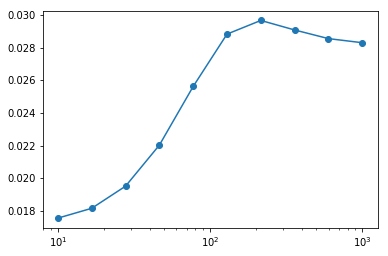

In [29]:
f = plt.figure()
ax = f.add_subplot(1,1,1)
ax.semilogx(np.logspace(1, 3, 10), Lbscorrs.mean(2).mean(1), 'o-')

# Compare quality of predictions for held-out data

### Huth:

In [97]:
# manually predict responses
Huthpred = np.dot(delHuthPstim, Hwt)

# # z-score predicted responses for each voxel
# zHuthpred = np.array([zscore(i) for i in Huthpred.T]).T

Text(0,0.5,'Num. voxels')

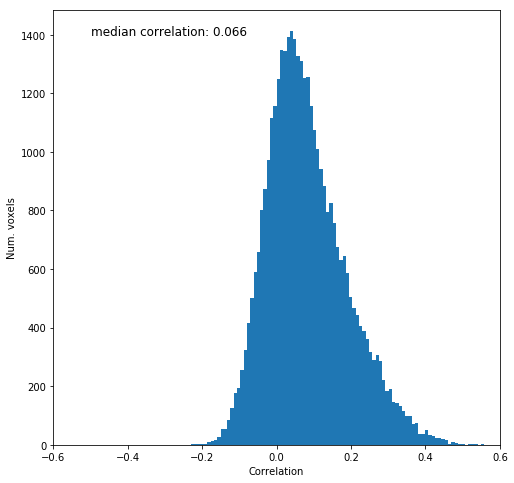

In [128]:
# distribution of real and predicted activity
Huth_voxcorrs = np.zeros((zPresp.shape[1],))
for vi in range(zPresp.shape[1]):
    Huth_voxcorrs[vi] = np.corrcoef(zPresp[:,vi], Huthpred[:,vi])[0,1]

f = plt.figure(figsize=(8,8))
ax = f.add_subplot(1,1,1)
ax.set_xlim(-.6, .6)
ax.text(x=-.5, y=1400, s=f'median correlation: {str(np.median(Huth_voxcorrs))[:5]}', size='large')
ax.hist(Huth_voxcorrs, 100) # histogram correlations with 100 bins
ax.set_xlabel("Correlation")
ax.set_ylabel("Num. voxels")

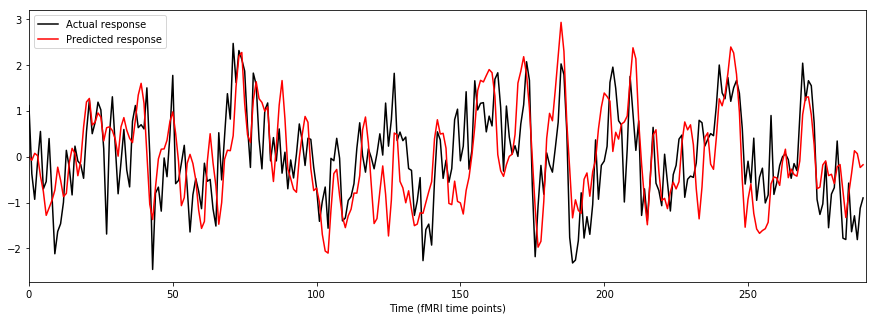

In [109]:
# visualize similarity for single voxel
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)

selvox = Huth_voxcorrs.argmax() # best-predicted voxel by Huth model

realresp = ax.plot(zPresp[:,selvox], 'k')[0]
# z-score predicted response to unit standard deviation
predresp = ax.plot(zHuthpred[:,selvox], 'r')[0]

ax.set_xlim(0, 291)
ax.set_xlabel("Time (fMRI time points)")

ax.legend((realresp, predresp), ("Actual response", "Predicted response"))
plt.show()

### LDA:

In [89]:
# manually predict responses
LDApred = np.dot(delLDAPstim, Lwt)

# # z-score predicted responses for each voxel
# zLDApred = np.array([zscore(i) for i in LDApred.T]).T

Text(0,0.5,'Num. voxels')

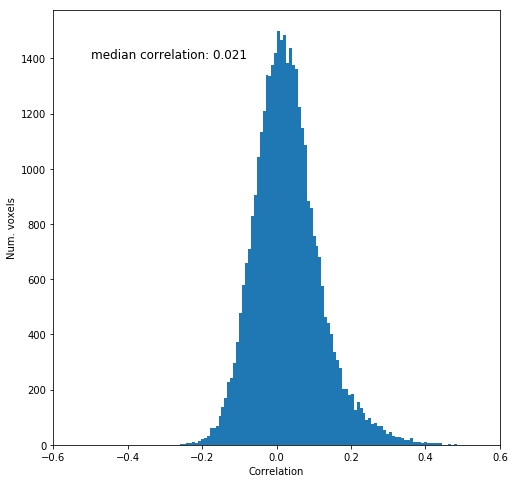

In [129]:
# distribution of real and predicted activity
LDA_voxcorrs = np.zeros((zPresp.shape[1],))
for vi in range(zPresp.shape[1]):
    LDA_voxcorrs[vi] = np.corrcoef(zPresp[:,vi], LDApred[:,vi])[0,1]

f = plt.figure(figsize=(8,8))
ax = f.add_subplot(1,1,1)
ax.set_xlim(-.6, .6)
ax.text(x=-.5, y=1400, s=f'median correlation: {str(np.median(LDA_voxcorrs))[:5]}', size='large')
ax.hist(LDA_voxcorrs, 100) # histogram correlations with 100 bins
ax.set_xlabel("Correlation")
ax.set_ylabel("Num. voxels")

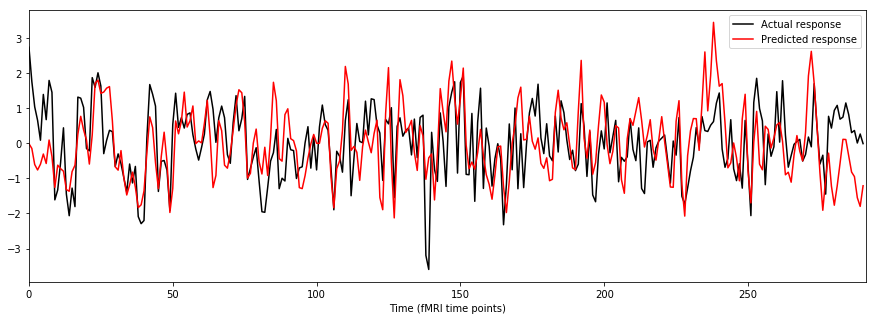

In [110]:
# visualize similarity for single voxel
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)

selvox = LDA_voxcorrs.argmax() # best-predicted voxel by LDA model

realresp = ax.plot(zPresp[:,selvox], 'k')[0]
# z-score predicted response to unit standard deviation
predresp = ax.plot(zscore(LDApred[:,selvox]), 'r')[0]

ax.set_xlim(0, 291)
ax.set_xlabel("Time (fMRI time points)")

ax.legend((realresp, predresp), ("Actual response", "Predicted response"))
plt.show()

DEBUG:matplotlib.backends.backend_pdf:Assigning font /b'F1' = '/usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
DEBUG:matplotlib.backends.backend_pdf:Embedding font /usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
DEBUG:matplotlib.backends.backend_pdf:Writing TrueType font.


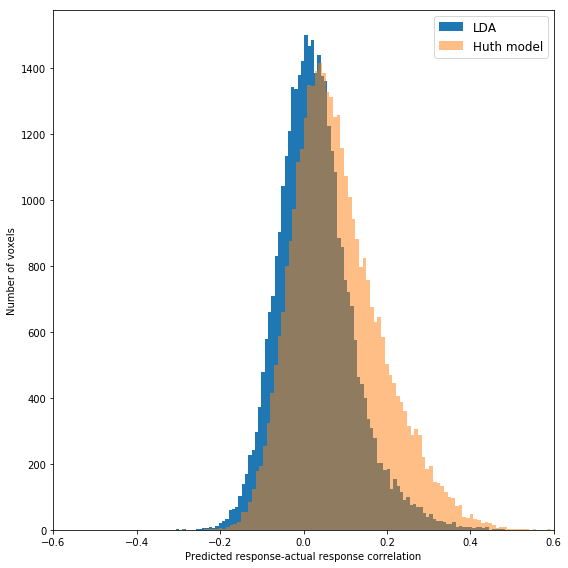

In [123]:
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(1,1,1)
ax.set_xlim(-.6, .6)
ax.hist(LDA_voxcorrs, 100, label='LDA') # histogram correlations with 100 bins
ax.hist(Huth_voxcorrs, 100, alpha=.5, label='Huth model') # histogram correlations with 100 bins
ax.legend(fontsize='large')
ax.set_xlabel("Predicted response-actual response correlation")
ax.set_ylabel("Number of voxels")
# plt.tight_layout()